<a href="https://colab.research.google.com/github/probabll/demo-mbr-nmt/blob/main/German-English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

This is a demo of sampling-based minimum Bayes risk decoding for NMT [(Eikema and Aziz, 2020)](https://www.aclweb.org/anthology/2020.coling-main.398/) for educational purposes. For a scalable implementation check [mbr_nmt](https://github.com/Roxot/mbr-nmt) and [(Eikema and Aziz, 2021)](https://arxiv.org/abs/2108.04718).

# Setting Up

This part will take care of the following:

1. Clone the repository `demo-mbr-nmt`.
2. Install dependencies.
3. Download pre-trained models.

In [1]:
!git clone https://github.com/probabll/demo-mbr-nmt.git

fatal: destination path 'demo-mbr-nmt' already exists and is not an empty directory.


In [2]:
cd demo-mbr-nmt

/content/demo-mbr-nmt


In [3]:
!git pull

Already up to date.


In [4]:
!pip install -r requirements.txt

In [5]:
!bash de-en.sh

--2021-09-06 16:11:10--  https://surfdrive.surf.nl/files/index.php/s/8lnmJPX3iXndRpz/download
Resolving surfdrive.surf.nl (surfdrive.surf.nl)... 145.100.27.67, 2001:610:108:203b:0:a11:da7a:5afe
Connecting to surfdrive.surf.nl (surfdrive.surf.nl)|145.100.27.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1097465344 (1.0G) [application/x-tar]
Saving to: ‘models/fairseq/de-en.tar’

models/fairseq/de-e 100%[===================>]   1.02G  23.4MB/s    in 52s     

2021-09-06 16:12:02 (20.3 MB/s) - ‘models/fairseq/de-en.tar’ saved [1097465344/1097465344]

Uncompressing
._de-en
de-en/
de-en/._prep-newstest2018.sh
de-en/prep-newstest2018.sh
de-en/._dict.de.txt
de-en/dict.de.txt
de-en/._.DS_Store
de-en/.DS_Store
de-en/._sentencepiece.bpe.model.de
de-en/sentencepiece.bpe.model.de
de-en/._sentencepiece.bpe.model.en
de-en/sentencepiece.bpe.model.en
de-en/._README.md
de-en/README.md
de-en/._sentencepiece.bpe.vocab.de
de-en/sentencepiece.bpe.vocab.de
de-en/._dict.en.txt
d

# Neural machine translation

Given an input $x$ (i.e., a sentence in a source language), a trained NMT model predicts a conditional distribution $Y|X=x, \theta$ over all possible target-language translations of $x$. 

The sample space $\mathcal Y$ of the model is the set of all sequences of the form $(y_1, \ldots, y_N)$ where $y_n$ belongs to a vocabulary of known target-language symbols, $N \ge 1$ is the sequence length, and $y_N$ is a special end-of-sequence (EOS) symbol.

An outcome $y \in \mathcal Y$ is assigned probability mass:

\begin{align}
P_{Y|X}(y|x,\theta) &= \prod_{n=1}^{N} \mathrm{Cat}(y_n|f(x, y_{<n}; \theta))
\end{align}

where $y_{<n}$ is the sequence of tokens before the $n$th token, and $f(\cdot; \theta)$ is a neural network architecture with parameters $\theta$.


In the previous section you downloaded a pre-trained NMT model, that is, a specific choice of architecture (a Transformer encoder-decoder model) and a collection of parameters $\theta$. This model was trained to maximise the model's likelihood given a dataset of observations (i.e., our training data). 

You can load the trained model using `demo.load`:

In [6]:
from demo import load

The next line will take a moment.

In [7]:
model = load(src='de', tgt='en', np_seed=10, torch_seed=10)

Given an input, a trained model can assign probability to known translations, as well as, be used to draw translation candidates.

## Assigning probability 

Let's first see how to compute the surprisal of a given translation (i.e, the negative logarithm of the outcome's probability):

In [8]:
# Here is an example input in German and its human translation in English
example_x = "Es war noch nie leicht, ein rationales Gespräch über den Wert von Gold zu führen."
example_y = "It has never been easy to have a rational conversation about the value of gold."

In [9]:
# Surprisal is the negative of the log-probability of the outcome
surp_obs = model.x2y.surprisal(
    example_x, 
    example_y
)['surprisal']
print(surp_obs, (-surp_obs).exp())

tensor([3.3471]) tensor([0.0352])


## Drawing samples

Now let's see how to draw translation candidates from the model distribution:

In [10]:
for y in model.x2y.ancestral_sampling(example_x, num_samples=10)['output']:
    print(y)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


It has never been easy to talk rationally about gold's value.
It has never been easy to start a rational conversation about the value of gold.
It has never been easy to make a rational talk about the value of gold.
It has never been easy to begin a rational conversation on the value of gold.
It has never been easy to address the value of gold in a rational manner.
It has never been easy to handle a rational conversation on the value of gold.
Discussing gold's value rationally has never been easy.
It is never easy to call a rational discussion about gold's value.
It is never easy to talk rationally about gold value.
We always enjoy discussing the value of gold.


## Predicting a translation

Given an input sentence $x$, a trained model predicts an entire distribution $Y|X=x, \theta$ over the space $\mathcal Y$ of possible translations. 

In order to pick a single translation candidate as our preferred translation, we need to introduce a criterion for decision making. Next, we recap two such criteria.

### Maximum-a-posterior decoding 

MAP decoding tells us to pick the most probable translation.
\begin{align}
y^{\mathrm{mode}} &= \arg\max_{h \in \mathcal Y} ~ P_{Y|X}(h|x, \theta)
\end{align}

As the space $\mathcal Y$ is unbounded and the NMT model makes no Markov assumptions, this search is intractable. In practice, we approximate the decision rule searching through a beam of probable translations. 

\begin{align}
y^{\mathrm{beam}} &= \arg\max_{h \in \mathrm{beam}(x)} ~  P_{Y|X}(h|x, \theta)
\end{align}

In [11]:
beam = model.x2y.beam_search(example_x, beam_size=5)
for y, surp in zip(beam['output'], beam['surprisal']):
    print(f"{surp:.4f}\t{y}")
y_map = beam['output'][0]

2.4119	It has never been easy to talk rationally about the value of gold.
3.3470	It has never been easy to have a rational conversation about the value of gold.
3.6803	It has never been easy to discuss the value of gold rationally.
4.6698	It has never been easy to discuss the value of gold in a rational way.
5.7409	It has never been easy to discuss the value of gold in a rational manner.


**Some things to note**

* Often, the beam search translation has much higher probability (lower suprisal) than the reference translation.
* Often, if you increase the `beam_size` parameter, beam search will find translations that are even more probable (even lower surprisal).


### Minimum Bayes risk decoding

MBR decoding tells us to pick the translation that has highest expected utility:

\begin{align}
y^{\text{mbr}} &= \arg\max_{h \in \mathcal Y} ~ \underbrace{\mathbb E[u(Y, h; x)|x, \theta]}_{=: \mu_u(h; x, \theta)} \\
&= \arg\max_{h \in \mathcal Y} ~ \sum_{y \in \mathcal Y} u(y, h; x) P_{Y|X}(y|x, \theta)
\end{align}

where a utility function $u(y, h; x)$ quantifies the benefit of choosing $h$ as the translation of $x$, when $y$ is the correct (or preferred) translation.

There are two sources of intractability in MBR decoding. First,  just like in MAP decoding, the search space (i.e., the sample space $\mathcal Y$) is unbounded. Second, for any given candidate translation $h$, the expected utility $\mu_u(h; x, \theta) = \mathbb E[u(Y, h; x)|x, \theta]$ is intractable to compute. 

[Eikema and Aziz (2020)](https://www.aclweb.org/anthology/2020.coling-main.398/) propose to  

1. approximate the hypothesis space by a tractable subset of hypotheses $\mathcal H(x)$ obtained by sampling from the model;
2. approximate the expected value using Monte Carlo (MC).

The decision rule becomes

\begin{align}
y^{\text{smbr}} &= \arg\max_{h \in \mathcal H(x)} ~ \underbrace{\frac{1}{S} \sum_{s=1}^S u(y^{(s)}, h; x)}_{=: \hat\mu_u(h; x, \theta)}
\end{align}

where $y^{(s)} \sim Y|X=x, \theta$ is a sample from the NMT model (samples can be drawn efficiently via ancestral sampling).

For much more on sampling-based MBR see also [Eikema and Aziz (2021)](https://arxiv.org/abs/2108.04718).

We have prepared a number of helpers for the demo. 

In [12]:
from demo import SampleFromNMT, CachedSampler, Utility, MBR

Let's start by picking a utility function. In this demo we will assign utility using ChrF, a metric for automatic assessment of translation quality that works by comparing a translation candidate (a hypothesis) to a reference translation. 

In [13]:
from sacrebleu import sentence_chrf

For modularity, we need to make chrf compatible with `demo.Utility`, so here is a thin wrapper for that:

In [14]:
class ChrF(Utility):
    
    def __call__(self, src: str, hyp: str, ref: str) -> float:
        return sentence_chrf(hyp, [ref]).score  # note that chrf does not make use of the source sentence

chrf = ChrF()    

We then need a space of translation candidates, which MBR will score and rank. It's rather natural to use the NMT model itself to obtain such a hypothesis space, for example, via ancestral sampling:

In [15]:
# Duplicate translations do not change the result of MBR, so we discard duplicates
hyp_space = list(set(model.x2y.ancestral_sampling(example_x, num_samples=100)['output']))
len(hyp_space)

78

MBR requires a sampler for MC estimation, here we construct one.

In [16]:
nmt_sampler = SampleFromNMT(model.x2y, sample_size=100)

In [17]:
nmt_sampler(example_x)

['It has never been easy to talk rationally about the value of gold.',
 'It has never been easy to talk rationally about the value of gold.',
 'It has never been easy to talk rationally about the value of gold.',
 'It has never been easy to talk rationally about the value of gold.',
 'It has never been easy to talk rationally about the value of gold.',
 'It has never been easy to talk rationally about the value of gold.',
 'It has never been easy to talk rationally about the value of gold.',
 'It has never been easy to talk rationally about the value of gold.',
 'It has never been easy to talk rationally about the value of gold.',
 'It has never been easy to talk rationally about the value of gold.',
 'It has never been easy to have a rational conversation about the value of gold.',
 'It has never been easy to have a rational conversation about the value of gold.',
 'It has never been easy to have a rational conversation about the value of gold.',
 'It has never been easy to engage in 

Sampling on CPU may be considered an expensive operation, as in MBR we need to draw samples repeatedly for each candidate in the hypothesis space, we may consider using a single shared pool of samples for all candidates. `demo.CachedSampler` is a helper for that.

In [18]:
cached_sampler = CachedSampler(nmt_sampler, sample_size=30)

In [19]:
cached_sampler(example_x)

['It was never easy to discuss the value of gold rationally.',
 'Speaking of the value of gold has never been easy.',
 'It has never been easy to start through a rational conversation about the value of the gold.',
 'Bond value was never easy to breathe: It was never the easy moment to talk rationally about the value of gold.',
 'It has never been easy to make a rational conversation about currency values.',
 "It was never easy to talk rationally about gold's value.",
 'It has never been easy to discuss the value of gold in a rational manner.',
 'It has never been easy to discuss the value of gold more rationally.',
 'It has never been easy to discuss the value of gold more rationally.',
 'Any rational discussion on the value of gold has never been easy.',
 'Rational talk about a gold value has never been easy.',
 'Professor Guisenberg presided over an art test in 1952, designed by Thomas Altowski.',
 'It has never been easy to hold a rational conversation about currency values.',
 'It

In [20]:
mbr = MBR(chrf, cached_sampler)  # This version of MBR is what Eikema and Aziz (2021) call MBR N-by-S

In [21]:
y_mbr = mbr.decode(example_x, hyp_space)
y_mbr

'It has never been easy to make any rational conversation about the value of gold.'

In [22]:
chrf(example_x, y_map, example_y), chrf(example_x, y_mbr, example_y)

(0.6750826084658059, 0.8838063208456114)

In [24]:
from tabulate import tabulate

In [25]:
rows = []
for h, mu in sorted(zip(hyp_space, mbr.mus(example_x, hyp_space)), key=lambda pair: pair[1], reverse=True):
    quality = chrf(example_x, h, example_y)
    rows.append([mu, quality, h])
print(tabulate(rows, headers=['E[chrf(x, h, Y)]', 'chrf(x, h, ref)', 'candidate']))

  E[chrf(x, h, Y)]    chrf(x, h, ref)  candidate
------------------  -----------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
          0.664658           0.886664  It has never been easy to conduct a rational conversation about the value of gold.
          0.659087           0.90062   It has never been easy to say a rational conversation about the value of gold.
          0.655118           1         It has never been easy to have a rational conversation about the value of gold.
          0.641811           0.90094   It has never been easy to do a rational conversation about the value of gold.
          0.637213           0.835729  It has never been easy to have a rational conversation about gold's value.
          0.633381           0.883806  It has never been easy to make any rational conversation about the value of gold.
          0.628271      

### Analysis

In [27]:
import numpy as np
import matplotlib.pyplot as plt


Here we analyse whether a candidate's expected utility $\mu_u(h;x, \theta)$ correlates with utility against the ground-truth. As $\mu_u(h;x, \theta)$ is intractable to  compute, we rely on stochastic estimates $\hat\mu_u(h;x, \theta)$. 


In [74]:
from tqdm.auto import tqdm

We repeat the next experiment a number of times to account for variance, which may take some time.

In [75]:
estimates = []
# compute utility against reference
for h in hyp_space:    
    cached_sampler.reset()  #
    u = chrf(example_x, h, example_y)  # use human reference
    estimates.append([u])
repetitions = 10  # let's repeat MC estimation a number of times to get a sense of variance    
for _ in tqdm(range(repetitions)):
    cached_sampler.reset()  # reset cache to obtain a better view of variance
    for n, h in enumerate(hyp_space):         
        estimates[n].append(mbr.mu(example_x, h))
estimates = np.array(estimates)    

  0%|          | 0/10 [00:00<?, ?it/s]

In [76]:
estimates.shape

(78, 11)

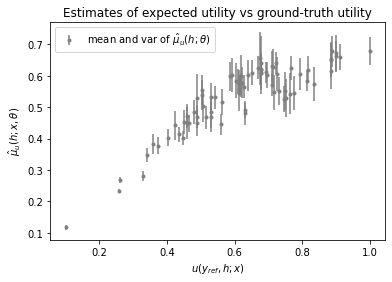

In [115]:
_ = plt.errorbar(
    estimates[:,0], estimates[:,1:].mean(1), yerr=estimates[:,1:].std(1) * 2, 
    marker='.', linestyle='', color='gray', label=r'mean and var of $\hat\mu_u(h;\theta)$')
_ = plt.title("Estimates of expected utility vs ground-truth utility")
_ = plt.xlabel(r'$u(y_{ref}, h; x)$')
_ = plt.ylabel(r'$\hat \mu_u(h; x, \theta)$')
_ = plt.legend()